<a href="https://colab.research.google.com/github/Gena5566/-/blob/main/Rengen_Detect_VoloV8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка YOLOv8
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/166.8 GB disk)


In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
%cd datasets

/content/datasets


In [ ]:
# Загрузка датасета с сайта Roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="05l603nUOAhm44eQSlNK")
project = rf.workspace("new-workspace-7hlof").project("phphph")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.131, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to phphph-1 in yolov8:: 100%|██████████| 3060/3060 [00:04<00:00, 650.86it/s] 


In [ ]:
# Функция для преобразования ограничивающих рамок в формате YOLO в xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Нужны высота и ширина изображения для денормализации
    # координаты ограничивающей рамки
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Денормализация координат.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Функция для построения изображений с ограничивающими рамками.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

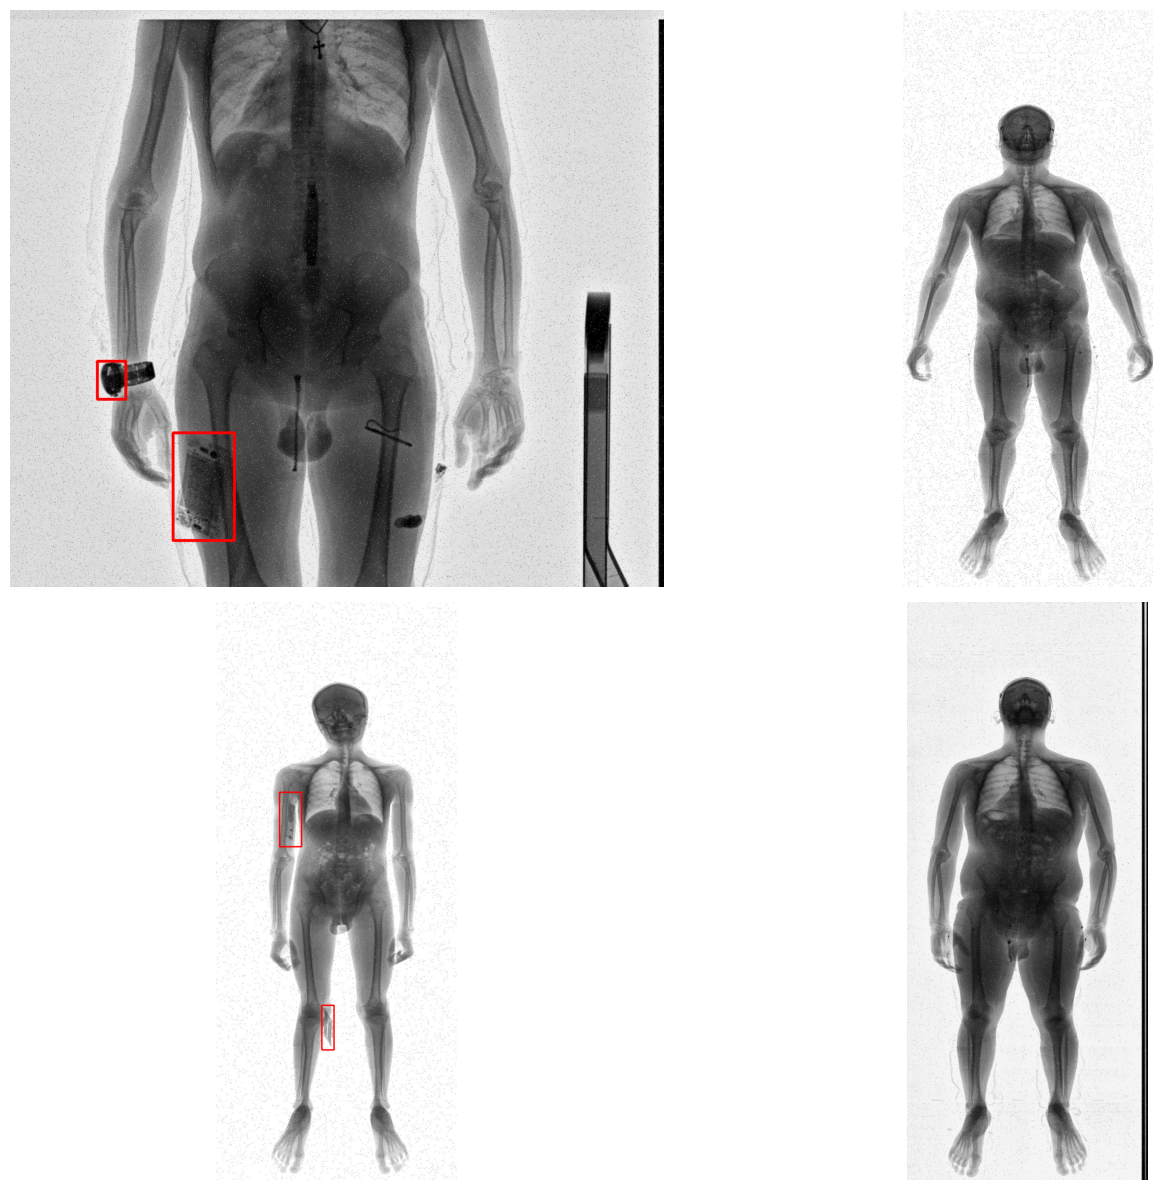

In [ ]:
# Визуализация  обучающих изображений.
plot(
    image_paths='/content/datasets/phphph-2/train/images',
    label_paths='/content/datasets/phphph-2/train/labels',
    num_samples=4,
)

In [ ]:
# Пример обучения на 100 эпохах YOLOv8x
EPOCHS = 100
!yolo task=detect mode=train model=yolov8x.pt imgsz=640 data=/content/datasets/phphph-2/data.yaml epochs={EPOCHS} batch=8 name=phphph_2

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/datasets/phphph-2/data.yaml, epochs=100, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=phphph_2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8

Оценка проверочных изображений

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8x.pt')  # load an official model
model = YOLO('/content/datasets/runs/detect/phphph_22/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients
val: Scanning /content/datasets/phphph-2/valid/labels.cache... 92 images, 5 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]
                   all         92        373      0.889      0.833      0.898      0.585
Speed: 0.8ms preprocess, 42.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val


array([    0.58472])

In [ ]:
!yolo task=detect mode=val model=/content/datasets/runs/detect/phphph_22/weights/best.pt name=yolov8x_eval data=/content/datasets/phphph-2/data.yaml

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients
val: Scanning /content/datasets/phphph-2/valid/labels.cache... 92 images, 5 backgrounds, 0 corrupt: 100% 92/92 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:11<00:00,  1.94s/it]
                   all         92        373      0.889      0.833      0.898      0.585
Speed: 8.1ms preprocess, 48.7ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to runs/detect/yolov8x_eval


In [ ]:
!yolo task=detect \
mode=predict \
model=/content/datasets/runs/detect/phphph_22/weights/best.pt \
source=/content/datasets/phphph-2/test/images \
imgsz=640 \
name=yolov8x_infer640 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients

image 1/61 /content/datasets/phphph-2/test/images/01-10-2021_2_png.rf.0ea79b55a6a35c70066d1e8a1cd9c492.jpg: 640x288 13 Nones, 117.6ms
image 2/61 /content/datasets/phphph-2/test/images/01-10-2021_8_png.rf.87b1f8c80e309d6dca50767e53a2d132.jpg: 640x288 11 Nones, 46.7ms
image 3/61 /content/datasets/phphph-2/test/images/04-10-2021_6_png.rf.e56ab9899e2bd45682c65ec1efa92249.jpg: 640x288 15 Nones, 46.6ms
image 4/61 /content/datasets/phphph-2/test/images/06-10-2021_11_png.rf.52afeada6a99dd51260db90cc094e0d7.jpg: 640x288 11 Nones, 46.7ms
image 5/61 /content/datasets/phphph-2/test/images/08-10-2021_4_png.rf.afda21d8be2f719a16c10f4a354ab3ab.jpg: 640x288 9 Nones, 46.7ms
image 6/61 /content/datasets/phphph-2/test/image

In [ ]:
# Функция визуализации тестовых изображений в сетке 2x2.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

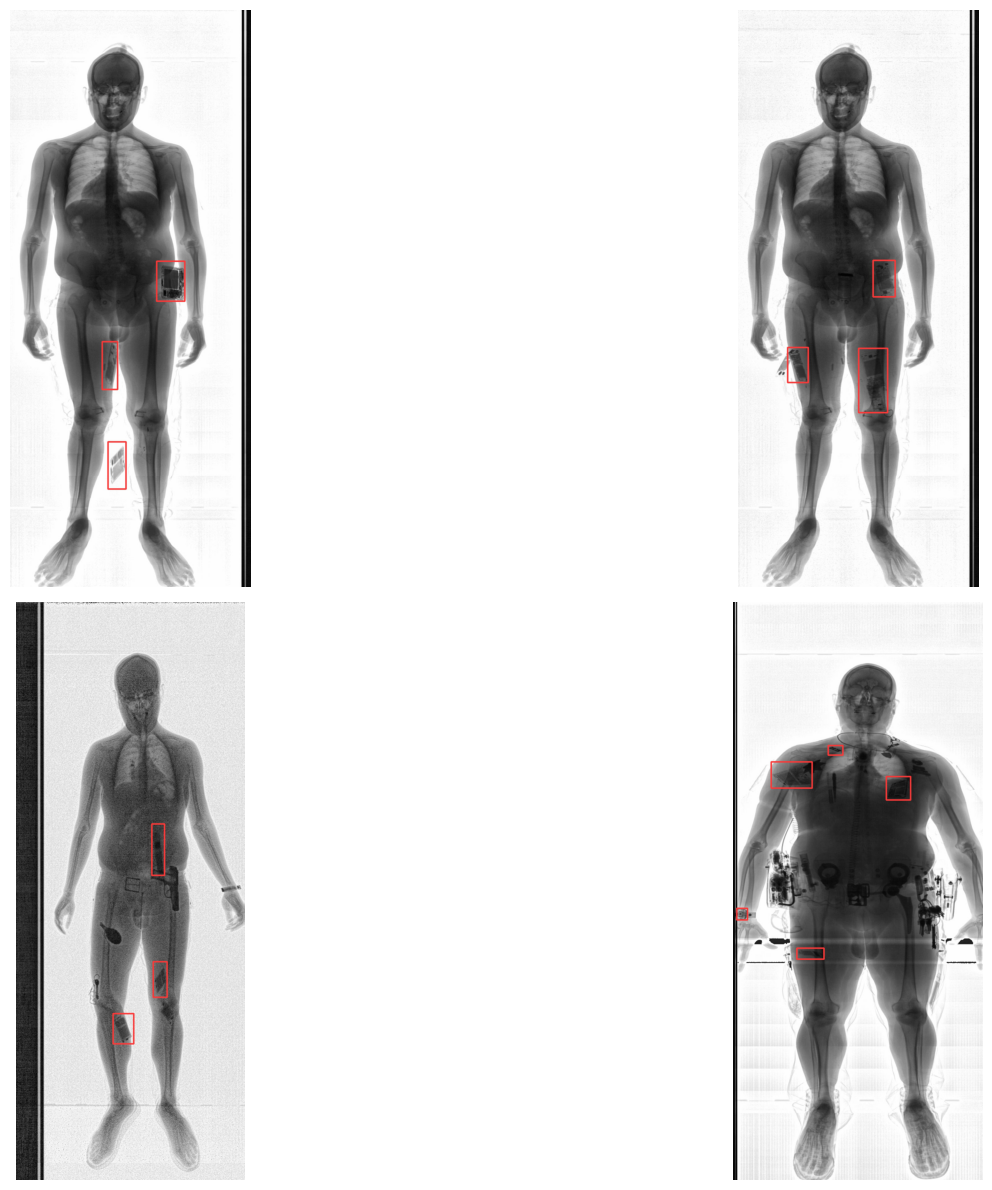

In [ ]:
visualize('/content/datasets/runs/detect/yolov8x_infer640')